No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate


<Figure size 3840x2880 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

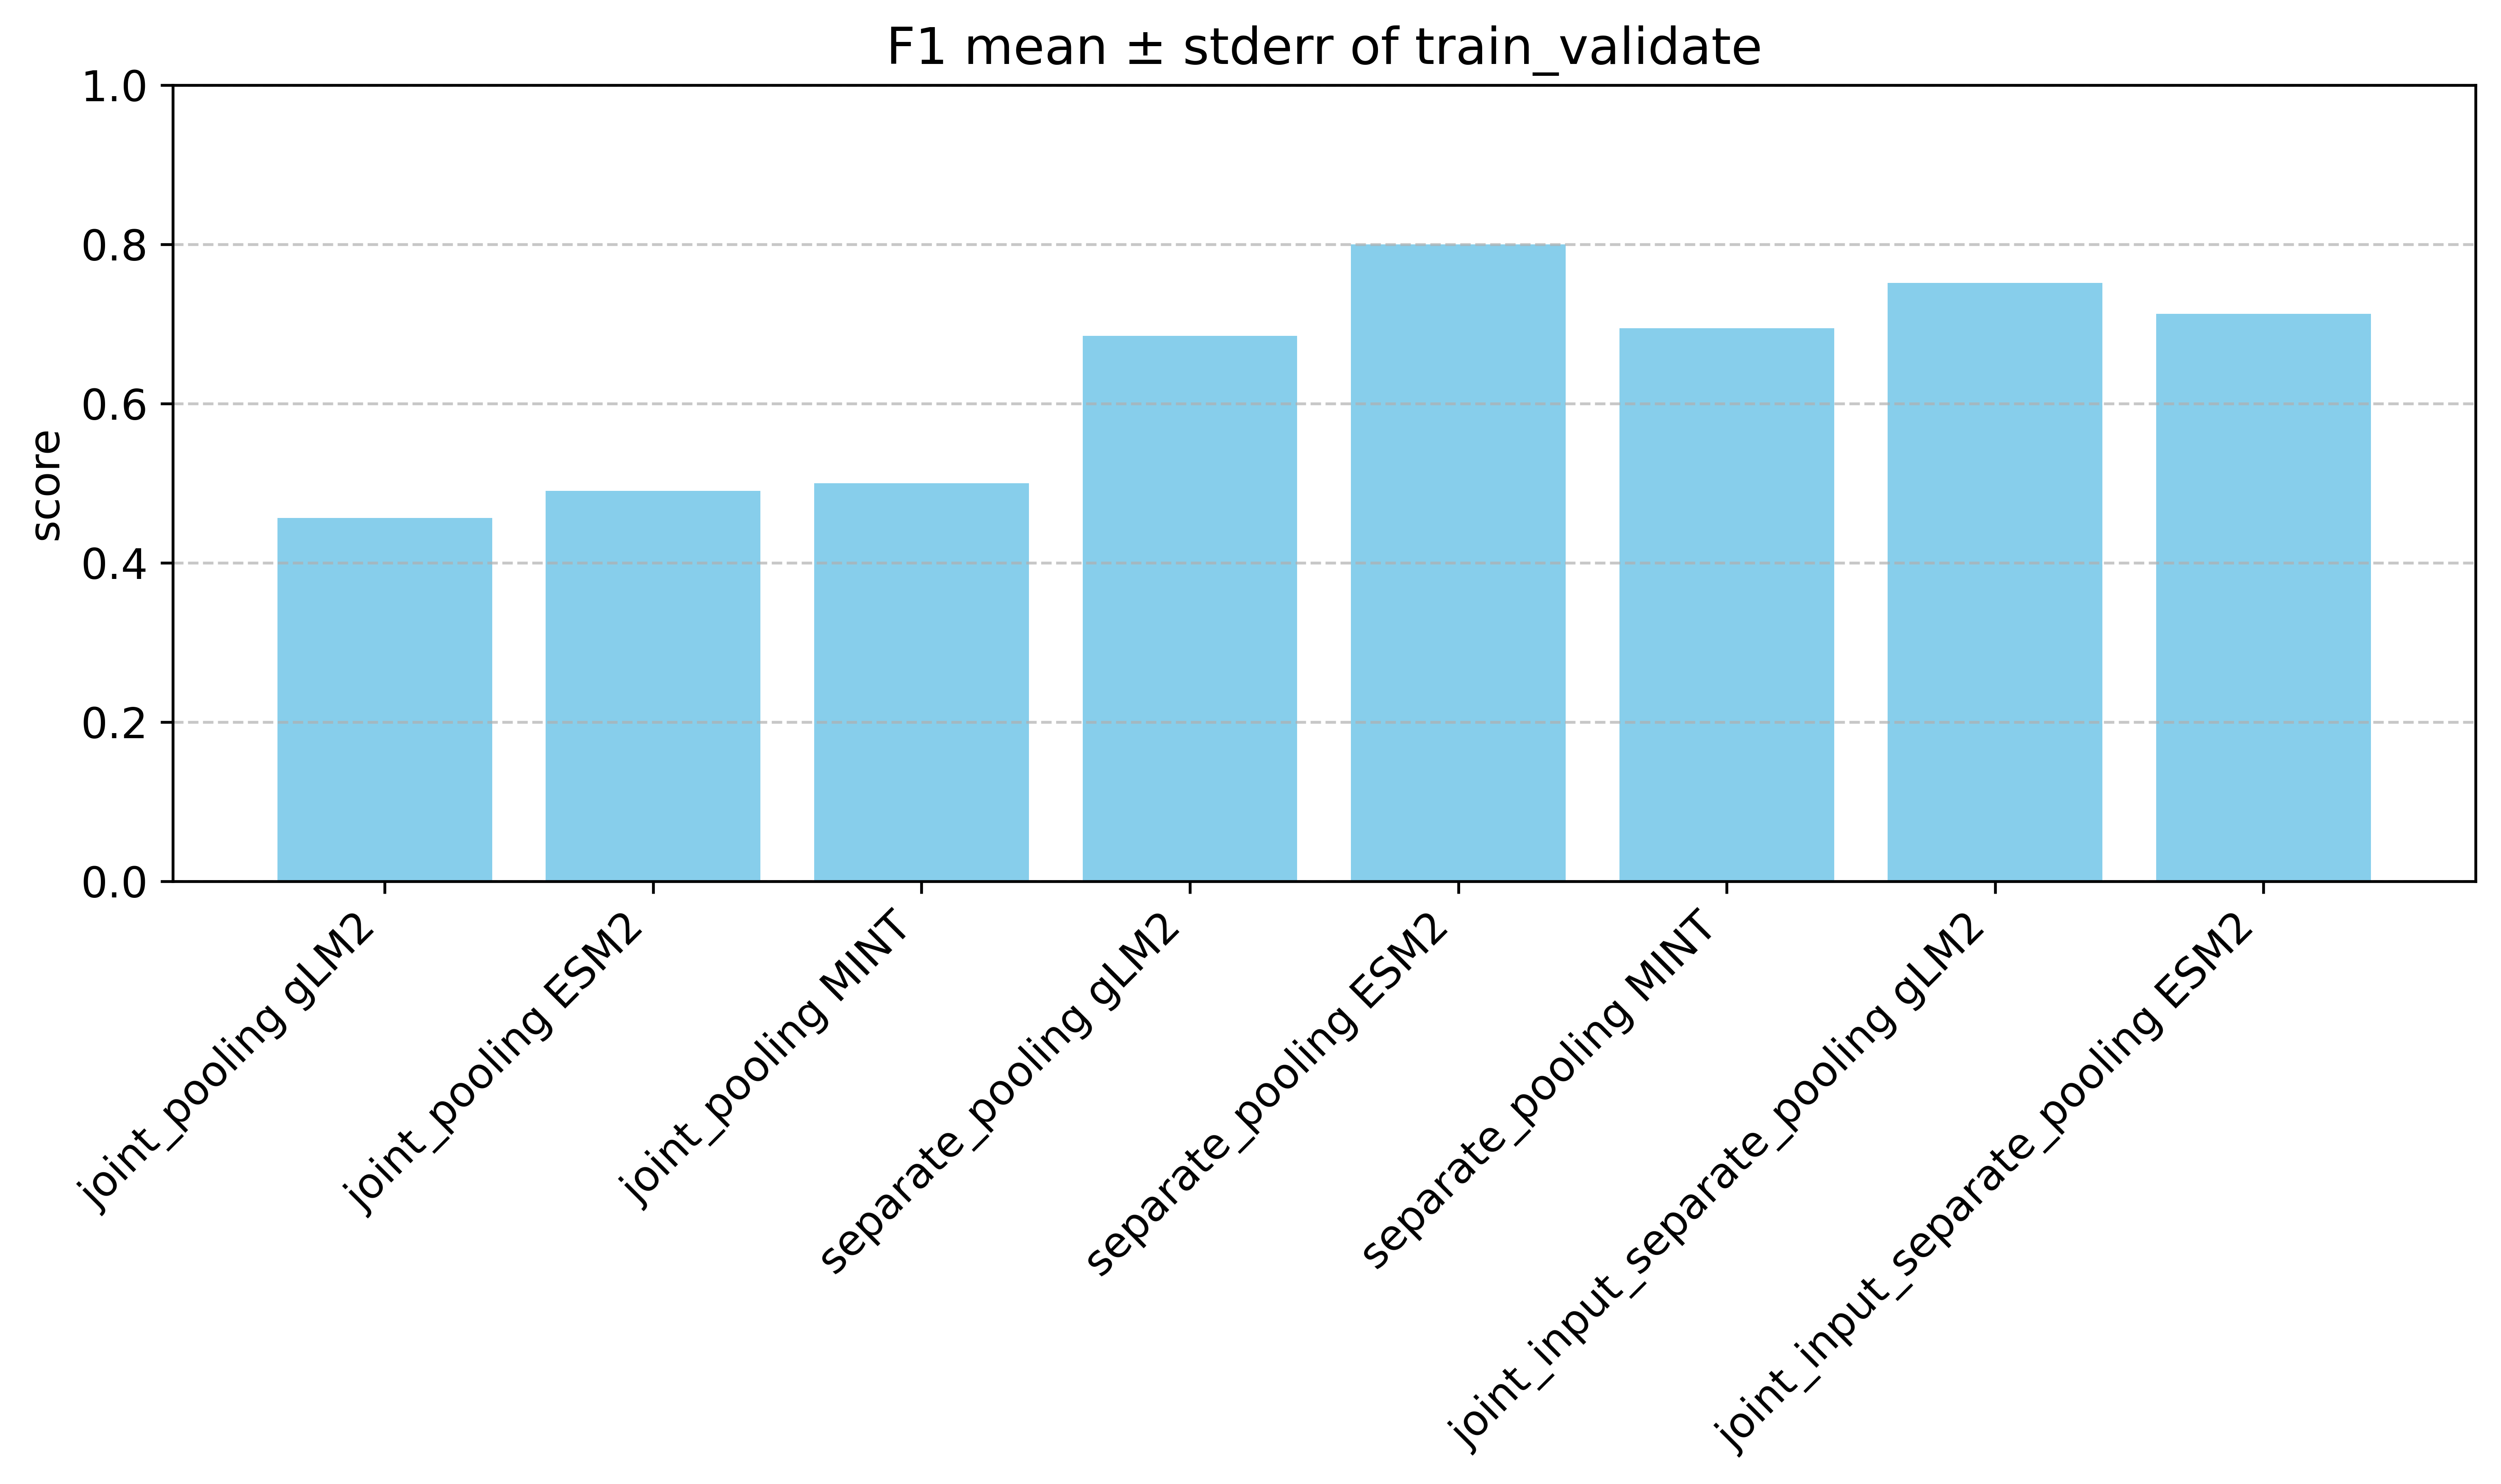

In [1]:
from Evaluator import Evaluator

# Not tested on CV with Evaluator class
evaluator = Evaluator(
    base_dir="/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/", 
    representations=["joint_pooling", "separate_pooling", "joint_input_separate_pooling"],
    biolms=["gLM2", "ESM2", "MINT"],
    dev_stage="train_validate",
    num_folds=5, 
    out_dir=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/",
    hyperparam="batch_size", hyperparam_value=32)

evaluator.run()

evaluator.rename_logs()

No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate


<Figure size 3840x2880 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

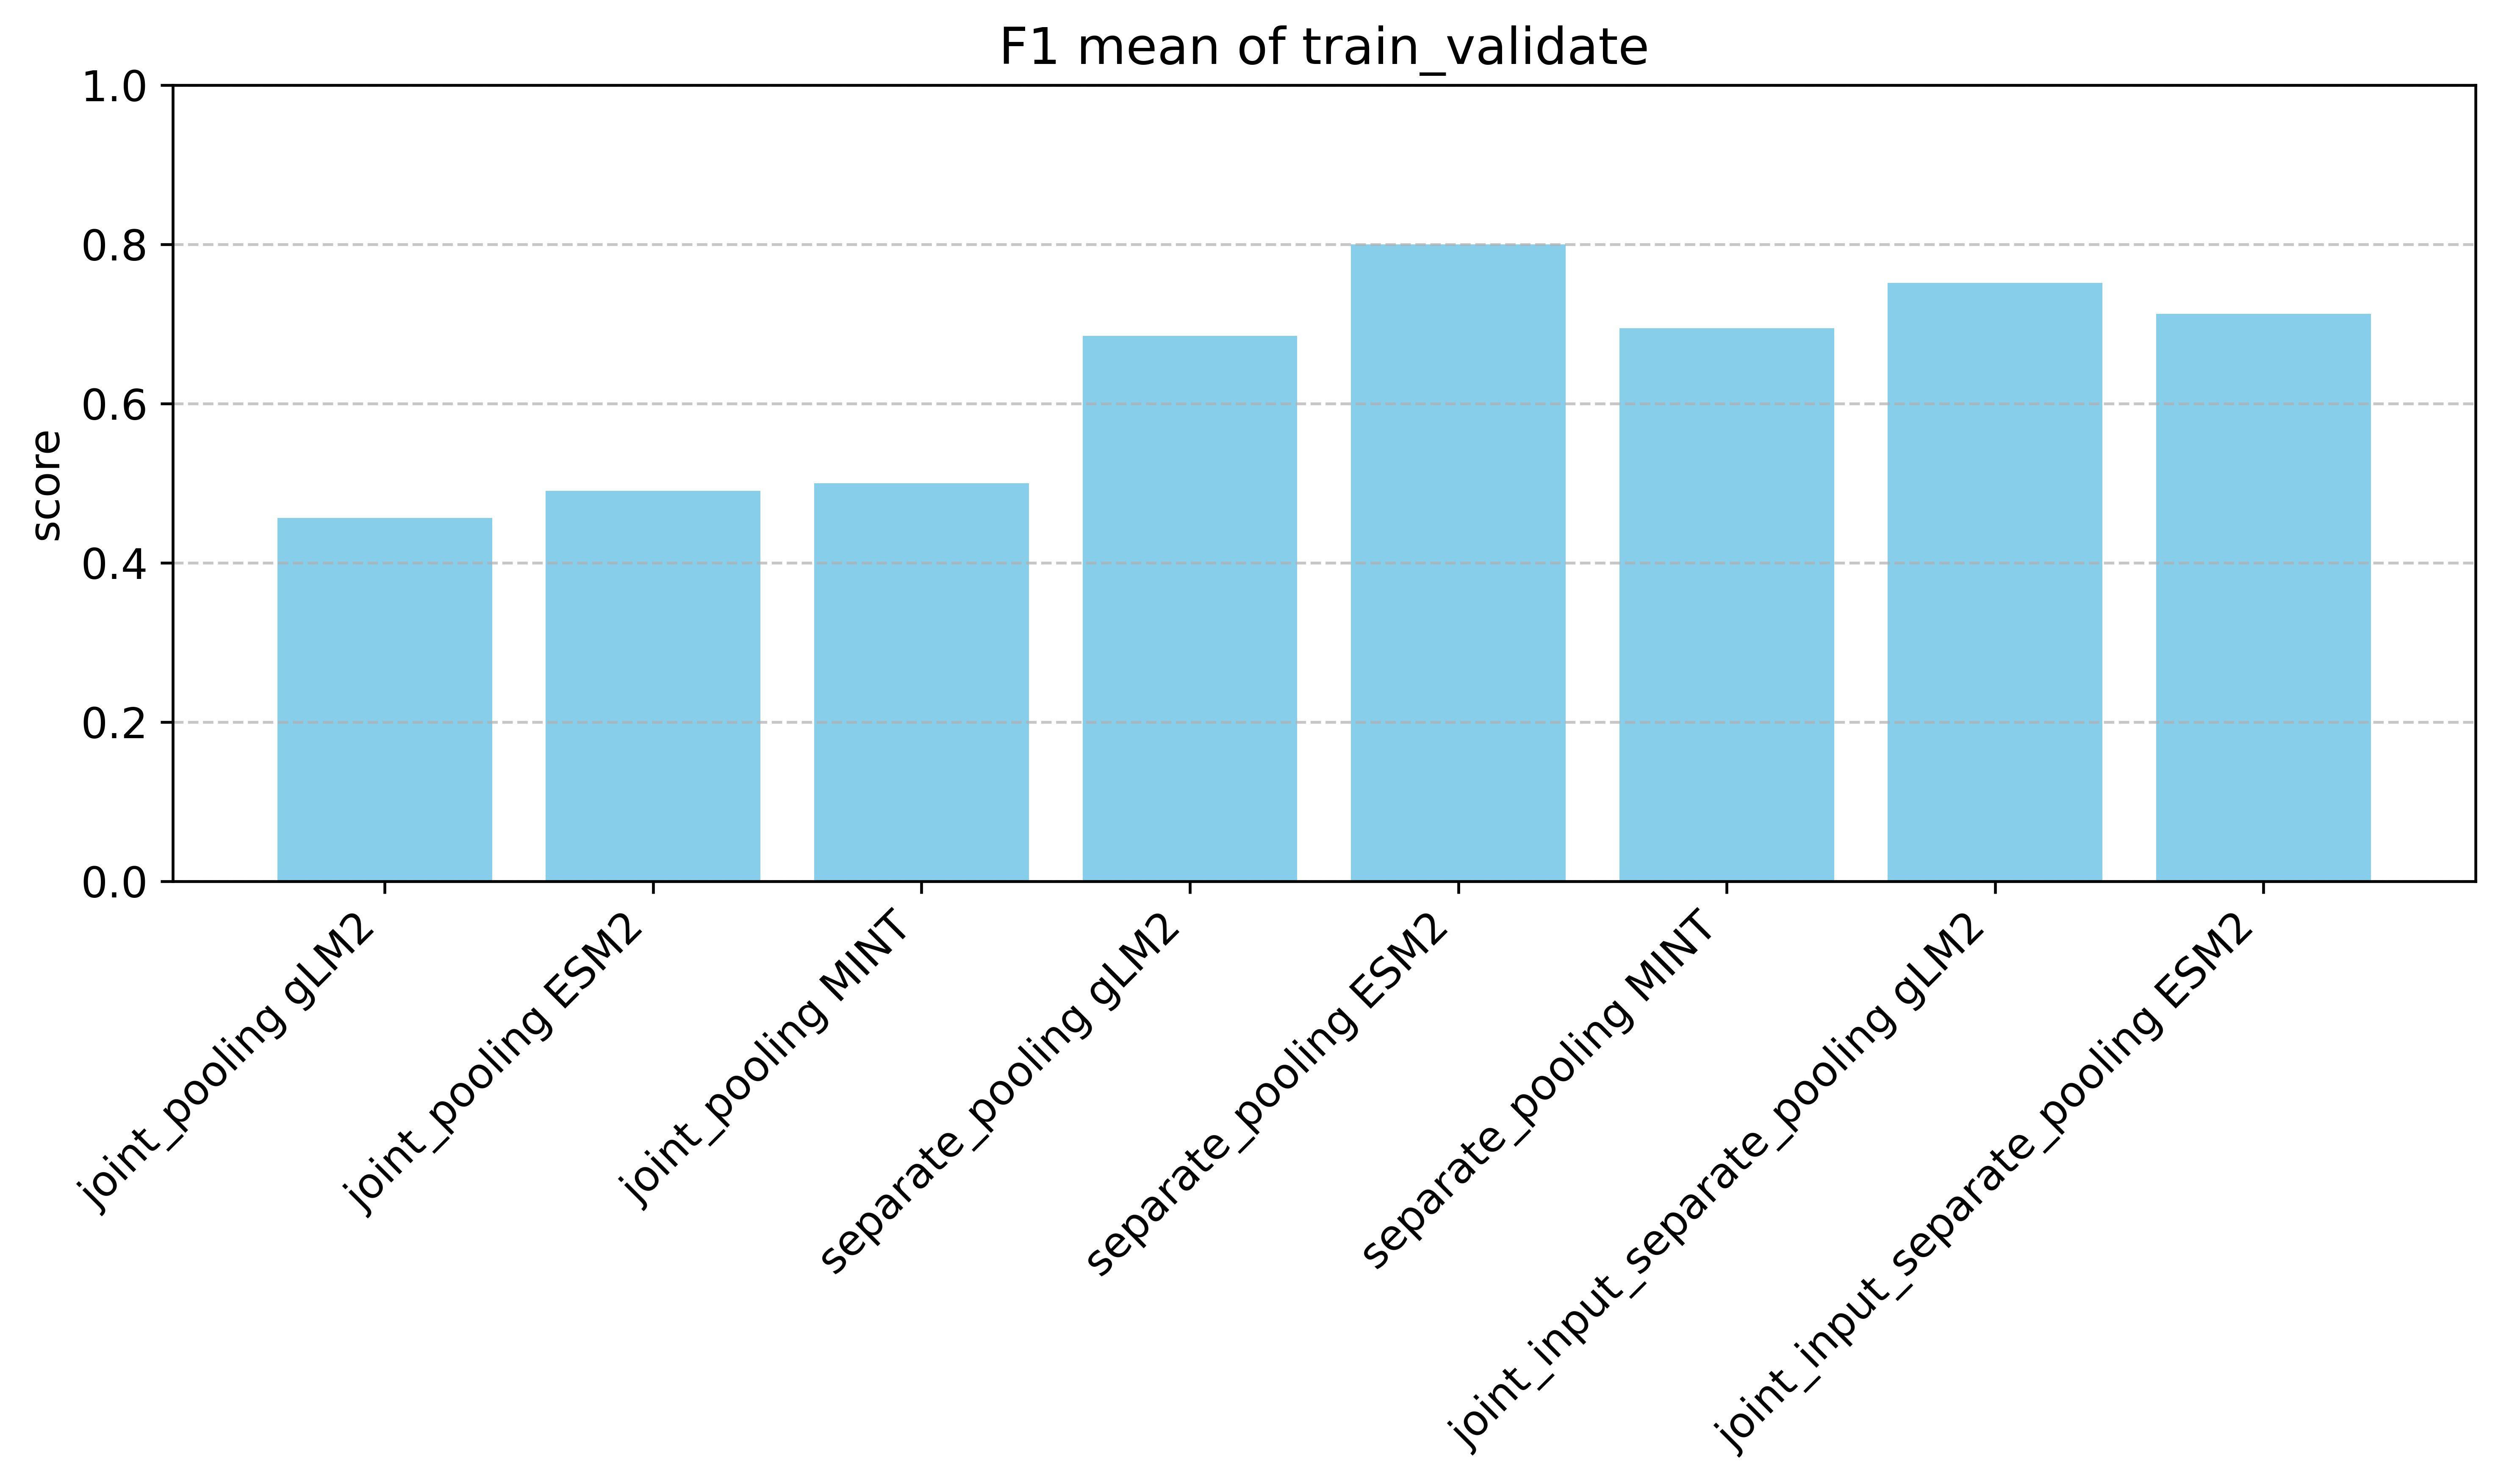

In [2]:
from Evaluator import Evaluator

# train_validate stage after CV

evaluator = Evaluator(
    base_dir="/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/", 
    representations=["joint_pooling", "separate_pooling", "joint_input_separate_pooling"],
    biolms=["gLM2", "ESM2", "MINT"],
    dev_stage="train_validate",
    num_folds=1, 
    out_dir=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/",
    hyperparam="", hyperparam_value="")

evaluator.run()